### Load libraries

In [7]:
import sys
import pathlib

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
import wandb.apis

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)

In [8]:
sys.path.append(str(GIT_ROOT))

from src.utils import runs_to_df

### Load data

In [9]:
api = wandb.Api()
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/adv-train",
    filters={"tags": {"$in": ["mnist20m"]}},
)

df_all = runs_to_df(runs)
df = df_all[df_all.state == "finished"]

In [10]:
print(sorted(df.n_train.unique()))

[1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 20000000]


### Plots

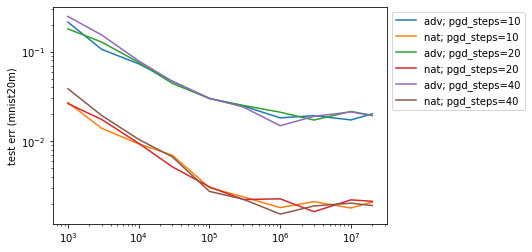

In [11]:
for pgd_steps in sorted(df.pgd_steps.unique()):
    cdf = df.query(f"pgd_steps == {pgd_steps}").sort_values("n_train")
    plt.plot(cdf.n_train, 1 - cdf.test_acc_adv, label=f"adv; {pgd_steps=}")
    plt.plot(cdf.n_train, 1 - cdf.test_acc_nat, label=f"nat; {pgd_steps=}")

# plt.ylim(0.08, 1)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("test err (mnist20m)")

# Place legend on outside top right of plot
plt.legend(bbox_to_anchor=(1, 1), loc="upper left");

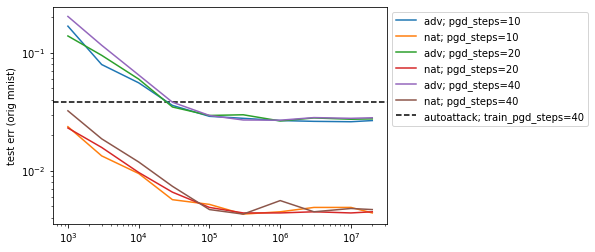

In [12]:
for pgd_steps in sorted(df.pgd_steps.unique()):
    cdf = df.query(f"pgd_steps == {pgd_steps}").sort_values("n_train")
    plt.plot(cdf.n_train, 1 - cdf.test_orig_acc_adv, label=f"adv; {pgd_steps=}")
    plt.plot(cdf.n_train, 1 - cdf.test_orig_acc_nat, label=f"nat; {pgd_steps=}")

plt.xscale("log")
plt.yscale("log")
plt.ylabel("test err (orig mnist)")
plt.axhline(
    1 - 0.9614, # From mnist-autoattack.ipynb
    color="black",
    linestyle="--",
    label="autoattack; train_pgd_steps=40",
    zorder=0,
)

# Place legend on outside top right of plot
plt.legend(bbox_to_anchor=(1, 1), loc="upper left");